In [58]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/Users/Heysoos/Documents/Pycharm Projects/Dissertation/02_critical_ising')

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from tqdm import tqdm

from models.isingCA_global_xi import isingCA

import seaborn as sns
from tqdm.auto import tqdm
plt.style.use('default') # if it's using the wrong style for some reason

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
# resolution of grid
RESX=128
RESY=128
RES = (RESX, RESY)

CHANNELS=1 # number of channels in grid
RADIUS=1
BETA=1/(RADIUS * RADIUS * CHANNELS)
PD=True
BS=256

ca = isingCA(RES, CHANNELS=CHANNELS, BETA=BETA, RADIUS=RADIUS).cuda()

In [85]:
temps = np.geomspace(1.8, 3.5, BS)
eq_steps = 10 ** 3
timesteps = 10 ** 3
num_runs = 3

# stats to save
save_every = 5
all_obvs = []
Cs = []

state, obvs = ca.initGrid()

Tc = 2.26924
# Iterate over temperature batches
for i in tqdm(range(0, len(temps), BS)):
    temp_batch = temps[i:i + BS]
    batch_len = len(temp_batch)  # Handle last batch size if not full
    
    all_obvs_run = []
    for j in range(num_runs):
        # Initialize states for the current batch
        state, obvs = ca.initGrid(BS=batch_len)
    
        # Modify states based on temperature
        state[:, -1] = torch.ones_like(state[:, -1]) * (1. / torch.tensor(temp_batch, dtype=state.dtype, device=state.device)).view(-1, 1, 1)
        
        # initialize spins to be annealed with the relation: m = (3(T - Tc)/Tc) ** 1/2 for T < Tc
        for i_temp, temp in enumerate(temp_batch):
            if temp < Tc:
                thresh = (3*(temp - Tc)/Tc) ** 1/2 
                state[i_temp, 0] = (torch.rand_like(state[i_temp, 0]) < thresh) * 2. - 1.
    
    
        # equilibrate for a bit
        for t in range(eq_steps):
            state, _ = ca.forward(state, pd=PD)
    
        all_obvs_batch = []
        for t in range(timesteps):
            state, obvs = ca.forward(state, pd=PD)
    
            if t % save_every == 0:
                all_obvs_batch.append(obvs.cpu().numpy())
    
        all_obvs_batch = np.stack(all_obvs_batch)
    
        e_t = all_obvs_batch[:, 0, :]
        e2_t = all_obvs_batch[:, 1, :]
        m_t = all_obvs_batch[:, 2, :]
        m2_t = all_obvs_batch[:, 3, :]
    
    
        E_t = np.mean(e_t, axis=0)
        M_t = np.mean(m_t, axis=0)
        C_t = (np.mean(e2_t, axis=0) - np.mean(e_t, axis=0) ** 2) * (1./temp_batch) ** 2
        X_t = (np.mean(m2_t, axis=0) - np.mean(m_t, axis=0) ** 2) * (1./temp_batch)
    
        all_obvs_run.append(np.stack([E_t, M_t, C_t, X_t]))
    
    all_obvs.append(np.stack(all_obvs_run))
# all_obvs = np.concatenate(all_obvs, axis=1)

100%|██████████| 1/1 [00:47<00:00, 47.07s/it]


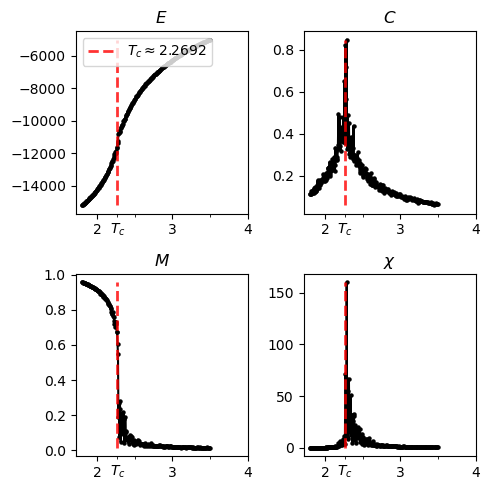

In [62]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

N = (RESX * RESY)

E = all_obvs[0, :]
M = all_obvs[1, :]
C = all_obvs[2, :] / N
X = N * all_obvs[3, :]

marker = '.-'
ms = 2.2

axes[0, 0].plot(temps, E, marker, ms=ms, c='k')
axes[1, 0].plot(temps, np.abs(M), marker, ms=ms, c='k')
axes[0, 1].plot(temps, C, marker, ms=ms, c='k')
axes[1, 1].plot(temps, X, marker, ms=ms, c='k')


axes[0, 0].set_title(r'$E$')
axes[1, 0].set_title(r'$M$')
axes[0, 1].set_title(r'$C$')
axes[1, 1].set_title(r'$\chi$')

data = [E, C, np.abs(M), X]
lw = 2
for i, ax in enumerate(axes.flatten()):
    ax.vlines(Tc, np.min(data[i]), np.max(data[i]), 'r', '--', lw=lw, alpha=0.8, label=rf'$T_c \approx {Tc:.4f}$')
    ax.set_xticks(list(ax.get_xticks())[1:] + [Tc], minor=True, labels=list(ax.get_xticklabels())[1:] + [r'$T_c$'])
axes[0, 0].legend(loc='upper left')
# sns.despline()

# axes[0, 1].set_ylim([0, 1e-3])
# axes[1, 1].set_ylim([0, 1])
plt.tight_layout()
plt.savefig('../figures/ising_stats.png', bbox_inches='tight')

### Again for different size networks

In [63]:
# sizes = [2 ** i for i in range(4, 11)]
sizes = [8, 16, 32, 64, 128]

# if using actual temperature
temps = np.geomspace(1.8, 3.5, BS)

# if using reduced temperature
# exp_nu = 1
# reduced_temps = np.linspace(-2, 2, 16*6)

eq_steps = 10 ** 3
timesteps = 2 * 10 ** 4

# stats to save
save_every = 5
all_obvs_multi = []
Cs = []


for size in sizes:
    print(f'Starting size = {size}')
    RES = (size, size)
    ca = isingCA(RES, CHANNELS=CHANNELS, BETA=BETA, RADIUS=RADIUS).cuda()

    state, obvs = ca.initGrid()

    all_obvs_N = []
    for i in tqdm(range(0, len(temps), BS)):
        # temp_batch = reduced_temps[i:i + BS] / (size ** (1./exp_nu)) * Tc + Tc
        
        temp_batch = temps[i:i + BS]
        batch_len = len(temp_batch)  # Handle last batch size if not full
        
        # Initialize states for the current batch
        state, obvs = ca.initGrid(BS=batch_len)
    
        # Modify states based on temperature
        state[:, -1] = torch.ones_like(state[:, -1]) * (1. / torch.tensor(temp_batch, dtype=state.dtype, device=state.device)).view(-1, 1, 1)
        
        # initialize spins to be annealed with the relation: m = (3(T - Tc)/Tc) ** 1/2 for T < Tc
        for i_temp, temp in enumerate(temp_batch):
            if temp < Tc:
                thresh = (3*(temp - Tc)/Tc) ** 1/2 
                state[i_temp, 0] = (torch.rand_like(state[i_temp, 0]) < thresh) * 2. - 1.
    
    
        # equilibrate for a bit
        for t in range(eq_steps):
            state, _ = ca.forward(state, pd=PD)
    
        all_obvs_batch = []
        for t in range(timesteps):
            state, obvs = ca.forward(state, pd=PD)
    
            if t % save_every == 0:
                all_obvs_batch.append(obvs.cpu().numpy())
    
        all_obvs_batch = np.stack(all_obvs_batch)
    
        e_t = all_obvs_batch[:, 0, :]
        e2_t = all_obvs_batch[:, 1, :]
        m_t = all_obvs_batch[:, 2, :]
        m2_t = all_obvs_batch[:, 3, :]
    
    
        E_t = np.mean(e_t, axis=0)
        M_t = np.mean(m_t, axis=0)
        C_t = (np.mean(e2_t, axis=0) - np.mean(e_t, axis=0) ** 2) * (1./temp_batch) ** 2
        X_t = (np.mean(m2_t, axis=0) - np.mean(m_t, axis=0) ** 2) * (1./temp_batch)
    
        all_obvs_N.append(np.stack([E_t, M_t, C_t, X_t]))
        
    all_obvs_N = np.concatenate(all_obvs_N, axis=1)
    all_obvs_multi.append(all_obvs_N)

Starting size = 8


100%|██████████| 1/1 [00:46<00:00, 46.93s/it]


Starting size = 16


100%|██████████| 1/1 [00:48<00:00, 48.44s/it]


Starting size = 32


100%|██████████| 1/1 [01:03<00:00, 63.65s/it]


Starting size = 64


100%|██████████| 1/1 [01:24<00:00, 84.64s/it]


Starting size = 128


100%|██████████| 1/1 [02:43<00:00, 163.16s/it]


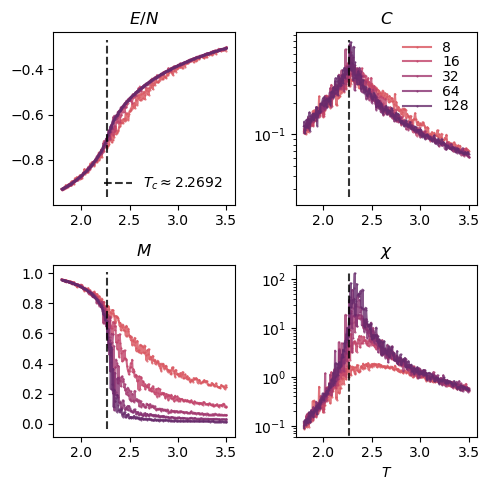

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(5, 5))

# color pallete for different sizes
# blues starting from 0.1
c_skip = 2
colors = sns.color_palette("flare", len(sizes) + c_skip)[c_skip:]
# colors = sns.color_palette('Blues', np.linspace(0.1, 1, len(sizes)))

for i_s, size in enumerate(sizes):  
    N = (size * size)
    
    E = all_obvs_multi[i_s][0, :] / N
    M = all_obvs_multi[i_s][1, :]
    
    C = all_obvs_multi[i_s][2, :] / N
    X = N * all_obvs_multi[i_s][3, :]

    marker = '.-'
    ms=1.
    c = colors[i_s]
    alpha = 0.8
    axes[0, 0].plot(temps, E, marker, ms=ms, c=c, alpha=alpha)
    axes[1, 0].plot(temps, np.abs(M), marker, ms=ms, c=c, alpha=alpha)
    axes[0, 1].plot(temps, C, marker, ms=ms, label=f'{size}', c=c, alpha=alpha)
    axes[1, 1].plot(temps, X, marker, ms=ms, c=c, alpha=alpha)


    axes[0, 0].set_title(r'$E/N$')
    axes[1, 0].set_title(r'$M$')
    axes[0, 1].set_title(r'$C$')
    axes[1, 1].set_title(r'$\chi$')
    
    

data = [E, C, np.abs(M), X]
for i, ax in enumerate(axes.flatten()):
    y_min, y_max = ax.get_ylim()
    ax.vlines(Tc, y_min, y_max, 'k', '--', alpha=0.8, label=rf'$T_c \approx {Tc:.4f}$' if i == 0 else None)
    # ax.set_xticks(list(ax.get_xticks())[1:] + [Tc], minor=True, labels=list(ax.get_xticklabels())[1:] + [r'$T_c$'])
axes[0, 0].legend(loc='lower right', frameon=False)
axes[0, 1].legend(frameon=False, borderpad=0.1, labelspacing=0.05, loc='upper right', ncol=1)

axes[1, 1].set_yscale('log')
axes[0, 1].set_yscale('log')
axes[1, 1].set_xlabel(r'$T$')
# axes[1, 0].set_xlabel(r'$T$')

plt.tight_layout()
plt.savefig('../figures/ising_stats_multiscale.pdf', bbox_inches='tight')

## Collapse the curves

Rescaled temperature:
$$ t = \frac{(T - T_c)}{T_C}$$
$$ \tilde{t} = t L^{1/\nu} $$

Rescaled Specific Heat:
$$ \tilde{C}(t, L) = L^{-\alpha/\nu} C(t, L) $$

Rescaled Susceptibility:
$$ \tilde{\chi}(t, L) = L^{-\gamma/\nu} \chi(t, L) $$

where $T_c = 2.2691$, $\alpha = 0$, $\gamma = 7/4$, and $\nu = 1$ is known for the 2D Ising model.

In [65]:
exp_alpha = 0
exp_nu = 1
exp_gamma = 7/4

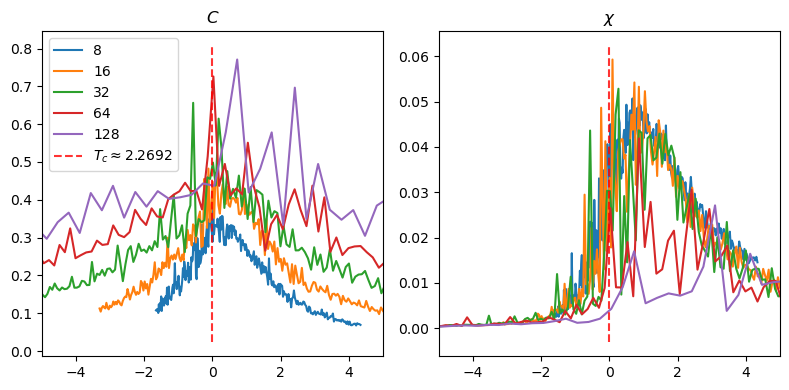

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))


for i_s, size in enumerate(sizes):
    
    # define the rescaling factors
    rescaled_temps = ((temps - Tc) / Tc) * (size ** (1./exp_nu))
    
    C_L = size ** (-exp_alpha / exp_nu)
    X_L = size ** (-exp_gamma / exp_nu)
    
    N = (size * size)
    C = C_L * all_obvs_multi[i_s][2, :] / N
    X = X_L * N * all_obvs_multi[i_s][3, :]
    
    # C = [C_L * size * size * obv[2] for obv in all_obvs_multi[i_s]]
    # X = [X_L * size * size * obv[3] for obv in all_obvs_multi[i_s]]

    marker = '.'
    ms=2.2
    lw=2
    axes[0].plot(rescaled_temps, C, ms=ms, label=f'{size}')
    axes[1].plot(rescaled_temps, X, ms=ms)
    # axes[0].vlines(Tc, np.min(C), np.max(C)*10, 'r', '--', lw=lw, alpha=0.8, label=rf'$T_c$')
    # axes[1].vlines(Tc, np.min(C), np.max(C)*10, 'r', '--', lw=lw, alpha=0.8, label=rf'$T_c$')


    axes[0].set_title(r'$C$')
    axes[1].set_title(r'$\chi$')
    
    # axes[0].set_yscale('log')
    # axes[1].set_yscale('log')

for i, ax in enumerate(axes.flatten()):
    y_min, y_max = ax.get_ylim()
    ax.vlines(0, y_min, y_max, 'r', '--', alpha=0.8, label=rf'$T_c \approx {Tc:.4f}$')
axes[0].legend()
for ax in axes:
    ax.set_xlim([-5, 5])
plt.tight_layout()
# plt.savefig('ising_stats.png', bbox_inches='tight')